**Automated Detection of Violent Events in Video Streams**
The project's goal is to develop and implement an advanced deep learning model capable of automatically recognizing violent activities in video streams, an important concern for public safety and surveillance systems. Leveraging the power ofconvolutional neural networks (CNNs) and/or recurrent neural networks (RNNs), the project combines spatial and temporal data analysis to accurately identify instances of violence among individuals or groups within video footage.

**1. Data Collection and Preprocessing**
Our dataset comprises 1000 violence and 1000 non-violence videos, all sourced from YouTube videos. The violence videos within our dataset encompass real street fight situations recorded in various environments and conditions. In contrast, the non-violence videos are sourced from a broad spectrum of human actions, including sports, eating, walking, and more.

**Import Necessary Dependencies**

In [67]:
import cv2
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tqdm import tqdm
import torch
from keras.models import Sequential
from keras.layers import LSTM, Dense,Bidirectional,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
import numpy as np
import cv2
import torch
from torchvision import transforms

In [41]:
import tensorflow as tf
tf.__version__

'2.16.2'

**Video Dataset Compilation**

**Monter le Drive**

**List out the data from our dataset**

In [42]:
violence = os.listdir('../Real_Life_Violence_Dataset/Violence')
nonviolence = os.listdir('../Real_Life_Violence_Dataset/NonViolence')

In [43]:
violence_path = [os.path.join('../Real_Life_Violence_Dataset/Violence',name) for name in violence]
nonviolence_path = [os.path.join('../Real_Life_Violence_Dataset/NonViolence',name) for name in nonviolence]

In [44]:
violence_path[0]

'../Real_Life_Violence_Dataset/Violence/V_253.mp4'

**Preprocessing**

**Optionnal, will not be use in the next part.**

In [45]:
def preprocess_video(video_path, frame_interval=1, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Réduction du taux de trame en fonction de l'intervalle spécifié
        if cap.get(cv2.CAP_PROP_POS_FRAMES) % frame_interval == 0:
            # Redimensionnement du cadre à la taille cible
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
    cap.release()
    return frames

def data_augmentation(frames):
    augmented_frames = []
    for frame in frames:
        # Exemple de transformation: retournement horizontal
        flipped_frame = cv2.flip(frame, 1)
        augmented_frames.append(flipped_frame)
    return augmented_frames

In [46]:
# Exemple d'utilisation
video_frames = preprocess_video(violence_path[0], frame_interval=5, target_size=(224, 224))
augmented_frames = data_augmentation(video_frames)

**Model Design and Implementation:**

**Spatial Feature Extraction**: Utilize a pre-trained model (CNN, transformers),known for its effectiveness in image recognition tasks, to extract spatialfeatures from individual video frames.
InceptionV3

In [47]:
pretrained_model = InceptionV3()
# Create a new model for feature extraction
# Extract features from the second-to-last layer of the InceptionV3 model
pretrained_model = Model(inputs=pretrained_model.input,outputs=pretrained_model.layers[-2].output)
pretrained_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

**Frame Feature Extraction Function**¶
In this section, we define a function for extracting features from an individual frame using the previously configured feature extraction model.

In [48]:
def feature_extractor(frame):
    # Expand the dimensions of the frame for model compatibility
    img = np.expand_dims(frame, axis=0)

    # Use the pre-trained feature extraction model to obtain the feature vector
    feature_vector = pretrained_model.predict(img, verbose=0)

    # Return the extracted feature vector
    return feature_vector

**Video Frames Extraction Function**

In [49]:
def frames_extraction(video_path, SEQUENCE_LENGTH=16, IMAGE_WIDTH=299, IMAGE_HEIGHT=299, total_video=0):
    all_video_features = []

    for pos in tqdm(range(total_video)):
        frames_list = []
        video_reader = cv2.VideoCapture(video_path[pos])
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

        for frame_counter in range(SEQUENCE_LENGTH):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            success, frame = video_reader.read()
            if not success:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_frame = cv2.resize(frame_rgb, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_frame = resized_frame / 255
            features = feature_extractor(normalized_frame) # Assuming feature_extractor is defined elsewhere
            frames_list.append(features)

        # Pad the frames_list with zeros if it's shorter than SEQUENCE_LENGTH
        while len(frames_list) < SEQUENCE_LENGTH:
            frames_list.append(np.zeros_like(features)) # Assuming features is a NumPy array

        all_video_features.append(frames_list)
        video_reader.release()

    # Convert the list of features to a numpy array
    return np.array(all_video_features)

**we will only using 500 videos on both violence and non violence classes**

In [50]:
print("file exists?", os.path.exists("../Real_Life_Violence_Dataset/Violence/V_253.mp4"))

file exists? True


In [51]:
violence_features = frames_extraction(violence_path[:500],total_video=len(violence_path[:500]))
non_violence_features = frames_extraction(nonviolence_path[:500],total_video=len(nonviolence_path[:500]))

100%|██████████| 500/500 [20:18<00:00,  2.44s/it]


In [52]:
np.save('data_features/violence_features.npy',violence_features)# save the feature in our directory and make it reusable

In [53]:
np.save('data_features/non_violence_features.npy',non_violence_features)# save the feature in our directory and make it reusable

**Loading Non-Violence and Violence Feature Data**
In this section, we load the precomputed feature data for non-violence and violence videos. The features are stored in NumPy arrays.

In [55]:
non_violence_data = np.load('data_features/non_violence_features.npy')
violence_data = np.load('data_features/violence_features.npy')

In [56]:
violence_data[0].shape

(16, 1, 2048)

**Temporal Feature Extraction: That can be used with LSTM**

Creating LSTM Model and Preparing Data¶
In this section, we define an Bidirectional LSTM (Long Short-Term Memory) model for video classification and prepare the data for training.

In [57]:
# Create labels
violence_labels = np.zeros(len(violence_data))
nonviolence_labels = np.ones(len(non_violence_data))

# Combine features and labels
X = np.concatenate([violence_data, non_violence_data], axis=0)
y = np.concatenate([violence_labels, nonviolence_labels], axis=0)

In [58]:
len(X)# total samples

1000

In [59]:
X[0].shape# shape of each samples

(16, 1, 2048)

In [60]:
y[0:20]# first 20 labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [61]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

X_train_reshaped = X_train.reshape((X_train.shape[0], 16, 2048))# reshape to (16,2048)
X_test_reshaped = X_test.reshape((X_test.shape[0], 16, 2048))# reshape to (16,2048)

**LSTM Model Definition using Keras Functional API**

In [62]:
# Define the input layer
inputs = Input(shape=(16, 2048))

# Build the LSTM model using Functional API
x = Bidirectional(LSTM(200, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(200, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 2048)]        0         
                                                                 
 bidirectional (Bidirection  (None, 16, 400)           3598400   
 al)                                                             
                                                                 
 batch_normalization_94 (Ba  (None, 16, 400)           1600      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 16, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               400800    
 onal)                                                           
                                                           

**Compiling The Model**

In [63]:
# Compile your model with an appropriate loss and optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped,y_train,validation_data=(X_test_reshaped,y_test),epochs=4,batch_size=32)

Epoch 1/4
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.7887 - loss: 0.4314 - val_accuracy: 0.9000 - val_loss: 0.4762
Epoch 2/4
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9441 - loss: 0.1343 - val_accuracy: 0.8350 - val_loss: 0.3822
Epoch 3/4
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.9766 - loss: 0.0582 - val_accuracy: 0.9500 - val_loss: 0.2292
Epoch 4/4
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9784 - loss: 0.0430 - val_accuracy: 0.9550 - val_loss: 0.1650


In [64]:
## Save the model
model.save('../model.h5')

**Benchmark & Evaluation**

**Model evaluation**

In [69]:
# Load your model
model = load_model('../model.h5')

ValueError: Weight count mismatch for layer #0 (named bidirectional in the current model, bidirectional in the save file). Layer expects 9 weight(s). Received 6 saved weight(s)

In [26]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", accuracy[1])

7/7 [==============================] - 0s 24ms/step - loss: 0.1644 - accuracy: 0.9300
Test Accuracy: 0.9300000071525574


**Lets Test With Unseen Videos**

In [40]:
violence_features_test = frames_extraction(violence_path[510:540],total_video=len(violence_path[510:540]))
non_violence_features_test = frames_extraction(nonviolence_path[510:540],total_video=len(nonviolence_path[510:540]))

100%|██████████| 30/30 [01:27<00:00,  2.90s/it]


In [41]:
test_violence = violence_features_test.reshape((violence_features_test.shape[0], 16, 2048))
test_non_violence = non_violence_features_test.reshape((non_violence_features_test.shape[0], 16, 2048))

In [42]:
test_violence[0].shape

(16, 2048)

In [43]:
np.expand_dims(test_violence[0],axis=0).shape# if we do prediiction single video then we need to perform expand dim

(1, 16, 2048)

In [44]:
class_names = ['violence','non_violence']# class names

**Model Testing**

In [45]:
predicted_non_violence = [class_names[1] if i > 0.5 else class_names[0] for i in model.predict(test_non_violence)]# tested with non violence video
predicted_violence = [class_names[1] if i > 0.5 else class_names[0] for i in model.predict(test_violence)]# tested with violence video

1/1 [==============================] - 0s 48ms/step


In [46]:
predicted_non_violence

['non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'violence',
 'violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'non_violence',
 'violence',
 'violence',
 'non_violence',
 'non_violence',
 'non_violence']

In [47]:
predicted_violence

['violence',
 'violence',
 'non_violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence',
 'violence']

**Classification Report For The Model Prediction**

In [48]:
y_pred = model.predict(X_test_reshaped)
y_preds = [1 if i > 0.5 else 0 for i in y_pred]
# Generate a classification report
report = classification_report(y_test, y_preds)

# Print the classification report
print("Classification Report:\n", report)

7/7 [==============================] - 0s 23ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        98
         1.0       1.00      0.86      0.93       102

    accuracy                           0.93       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.93      0.93       200



**Confusion Matrix**

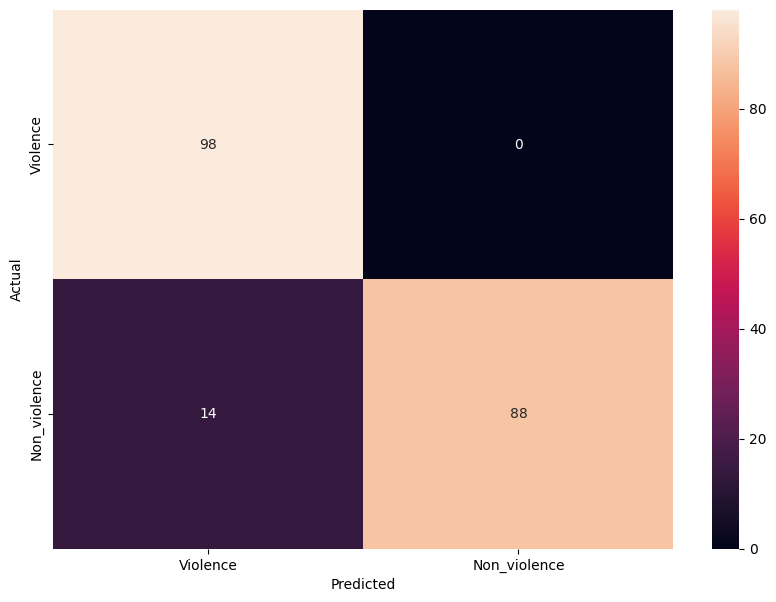

In [49]:
confusion_matrix = metrics.confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(confusion_matrix, index = ["Violence", "Non_violence"], columns = ["Violence","Non_violence" ])
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Courbe ROC_AUC**

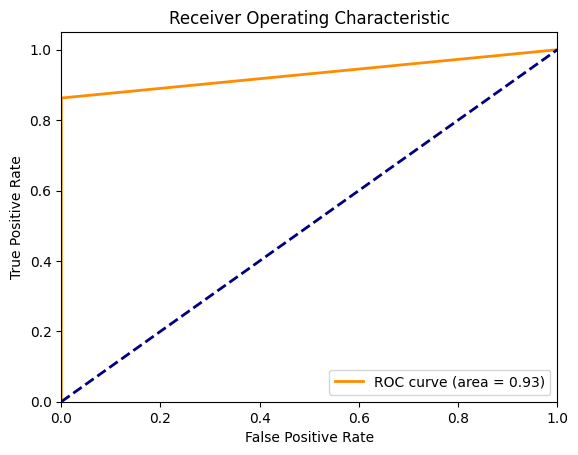

In [50]:
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

# Calcul du score AUC
roc_auc = roc_auc_score(y_test, y_preds)

# Tracé de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Precision-recall curve**

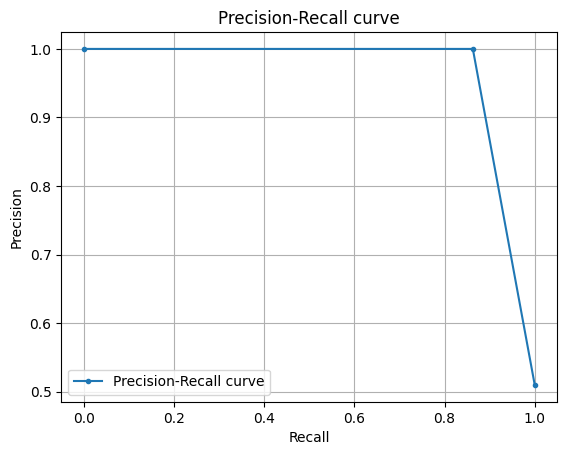

In [51]:
# Calcul de la courbe de précision-rappel
precisions, recalls, thresholds = precision_recall_curve(y_test, y_preds)

# Tracé de la courbe de précision-rappel
plt.figure()
plt.plot(recalls, precisions, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()